In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load and clean-up data
from numpy import nan
from pandas import read_csv
# univariate multi-step lstm
# import library 
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


## Preparing Data

In [153]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Belawan")
data

,Date,Hours,Hs [m],Angin [m/s]
0,1999-07-10 15:00:00,1,0.750,2.726197
1,1999-07-10 16:00:00,2,0.750,2.608670
2,1999-07-10 17:00:00,3,0.750,3.021065
3,1999-07-10 18:00:00,4,0.688,3.464277
4,1999-07-10 19:00:00,5,0.688,3.940771
...,...,...,...,...
437,1999-07-28 20:00:00,438,0.656,2.244146
438,1999-07-28 21:00:00,439,0.500,1.601026
439,1999-07-28 22:00:00,440,0.500,1.483258
440,1999-07-28 23:00:00,441,0.500,1.312014


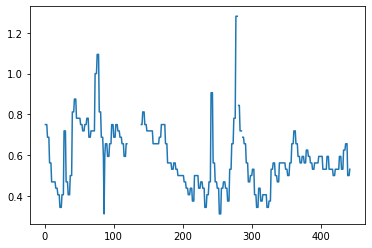

In [154]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [155]:
import copy
data_raw = copy.deepcopy(data)

### handling outliers

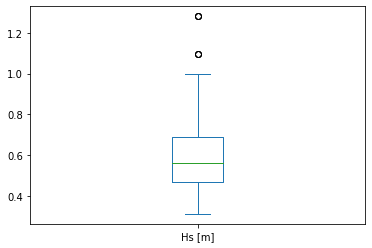

In [156]:
data['Hs [m]'].plot(kind='box', sharex=False, sharey=False)
plt.show()

In [157]:
# calculate q1, q3, iqr 
q1 = data['Hs [m]'].quantile(0.25)
q3 = data['Hs [m]'].quantile(0.75)
iqr = q3 - q1

In [158]:
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ]

75     1.094
76     1.094
77     1.094
276    1.281
277    1.281
278    1.281
Name: Hs [m], dtype: float64

In [159]:
# outlier atas
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ] = np.nan

#outlier bawah
data['Hs [m]'].loc[(data['Hs [m]']< q1-(1.5*iqr)) & (data['Hs [m]']>= q1-(3*iqr)) ] = np.nan

# nilai ekstrim bawah
data['Hs [m]'].loc[data['Hs [m]']> q3 + (3*iqr) ] = np.nan

# nilai ekstrim atas
data['Hs [m]'].loc[data['Hs [m]']< q1 - (3*iqr) ] = np.nan

<ipython-input-159-ec481b66d679>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-159-ec481b66d679>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-159-ec481b66d679>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-159-ec481b66d679>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

In [160]:
data.head()

,Date,Hours,Hs [m],Angin [m/s]
0,1999-07-10 15:00:00,1,0.750,2.726197
1,1999-07-10 16:00:00,2,0.750,2.608670
2,1999-07-10 17:00:00,3,0.750,3.021065
3,1999-07-10 18:00:00,4,0.688,3.464277
4,1999-07-10 19:00:00,5,0.688,3.940771


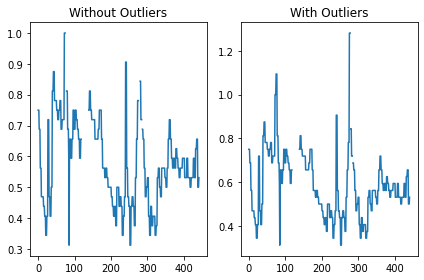

In [161]:
plt.subplot(121)
plt.plot(data['Hs [m]'])
plt.title('Without Outliers')

plt.subplot(122)
plt.plot(data_raw['Hs [m]'])
plt.title('With Outliers')

plt.tight_layout()

### Interpolation

In [162]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [163]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [164]:
# drop NaN value in dataframe data
data = data.dropna()

In [165]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [166]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [167]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [168]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [169]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-169-86623d2f7eed>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-169-86623d2f7eed>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-169-86623d2f7eed>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



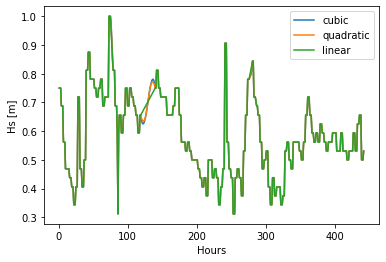

In [170]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

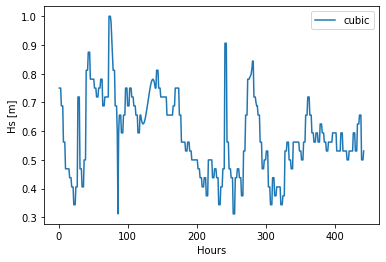

In [171]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

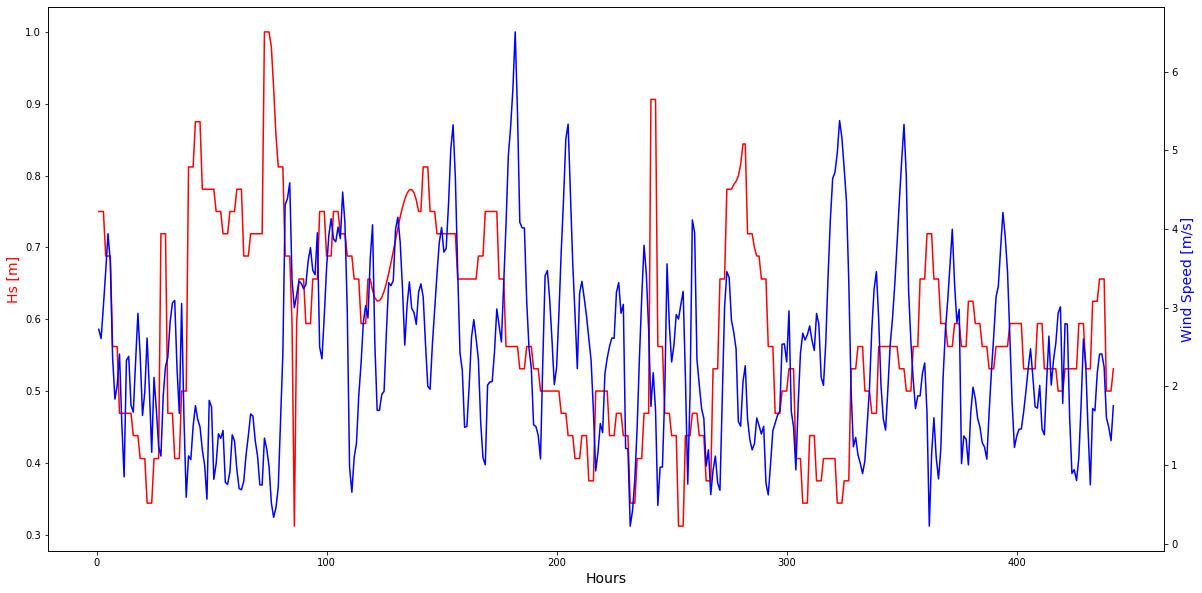

In [172]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

### splitting data

In [173]:
data_swh = data2[['Hs [m]','Angin [m/s]']]
type(data_swh), data_swh.shape

(pandas.core.frame.DataFrame, (442, 2))

In [174]:
len(data_swh)

442

In [175]:
data_swh[1:5]

,Hs [m],Angin [m/s]
1,0.750,2.608670
2,0.750,3.021065
3,0.688,3.464277
4,0.688,3.940771


**Pembagian data**

train = data 70% --> 1 - 2556

val = data 10% --> 2557 - 2928

test = data 20% --> 2929 - 3648

In [176]:
train = data_swh[:324]
val = data_swh[324:372]
test = data_swh[372:432]
train.shape, val.shape, test.shape

((324, 2), (48, 2), (60, 2))

In [177]:
type(train)

pandas.core.frame.DataFrame

In [178]:
# resturvture into windows of 12 hours data
train = array(split(train, round(len(train)/12)))
val = array(split(val, round(len(val)/12)))
test = array(split(test, round(len(test)/12)))
train.shape, val.shape, test.shape

((27, 12, 2), (4, 12, 2), (5, 12, 2))

In [179]:
data_train = train.reshape((train.shape[0]*train.shape[1],train.shape[2] ))
data_val = val.reshape((val.shape[0]*val.shape[1],train.shape[2] ))
data_train.shape, data_val.shape

((324, 2), (48, 2))

In [180]:
len(data_train)

324

In [181]:
def split_into_xy(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [182]:
n_steps_in, n_steps_out = 12, 12
X_train, y_train = split_into_xy(data_train,n_steps_in, n_steps_out)
X_val, y_val = split_into_xy(data_val,n_steps_in, n_steps_out)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((301, 12, 2), (301, 12, 2), (25, 12, 2), (25, 12, 2))

In [183]:
n_features = 2
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_train.shape,X_val.shape

((301, 12, 2), (25, 12, 2))

In [184]:
y_train = y_train[:,:,0].reshape((y_train.shape[0], y_train.shape[1],))
y_val = y_val[:,:,0].reshape((y_val.shape[0], y_val.shape[1],))
y_train.shape,y_val.shape

((301, 12), (25, 12))

In [185]:
X_train.shape[1]

12

## Model

In [186]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(LSTM(96, activation='sigmoid', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(98, activation='relu'))
model.add(RepeatVector(n_outputs))
model.add(LSTM(87, activation='relu'))
model.add(RepeatVector(n_outputs))
model.add(LSTM(60, activation='relu'))
model.add(RepeatVector(n_outputs))
model.add(LSTM(98, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(30, activation='relu')))
model.add(TimeDistributed(Dense(1)))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 96)                38016     
                                                                 
 repeat_vector_36 (RepeatVec  (None, 12, 96)           0         
 tor)                                                            
                                                                 
 lstm_43 (LSTM)              (None, 98)                76440     
                                                                 
 repeat_vector_37 (RepeatVec  (None, 12, 98)           0         
 tor)                                                            
                                                                 
 lstm_44 (LSTM)              (None, 87)                64728     
                                                                 
 repeat_vector_38 (RepeatVec  (None, 12, 87)          

In [187]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.3673 - root_mean_squared_error: 0.6061

10/10 [==============================] - 17s 1s/step - loss: 0.3673 - root_mean_squared_error: 0.6061 - val_loss: 0.3019 - val_root_mean_squared_error: 0.5495
Epoch 2/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.3172 - root_mean_squared_error: 0.5632

10/10 [==============================] - 7s 788ms/step - loss: 0.3157 - root_mean_squared_error: 0.5619 - val_loss: 0.2318 - val_root_mean_squared_error: 0.4815
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.2145 - root_mean_squared_error: 0.4631

10/10 [==============================] - 9s 982ms/step - loss: 0.2108 - root_mean_squared_error: 0.4592 - val_loss: 0.0718 - val_root_mean_squared_error: 0.2679
Epoch 4/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0821 - root_mean_squared_error: 0.2865

10/10 [==============================] - 7s 809ms/step - loss: 0.0810 - root_mean_squared_error: 0.2846 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1865
Epoch 5/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0594 - root_mean_squared_error: 0.2436

10/10 [==============================] - 9s 1s/step - loss: 0.0594 - root_mean_squared_error: 0.2438 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1802
Epoch 6/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0536 - root_mean_squared_error: 0.2316

10/10 [==============================] - 8s 877ms/step - loss: 0.0534 - root_mean_squared_error: 0.2311 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1657
Epoch 7/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.2173

10/10 [==============================] - 7s 798ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1382
Epoch 8/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.2071

10/10 [==============================] - 9s 1s/step - loss: 0.0424 - root_mean_squared_error: 0.2059 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 9/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0354 - root_mean_squared_error: 0.1880

10/10 [==============================] - 8s 876ms/step - loss: 0.0350 - root_mean_squared_error: 0.1870 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0967
Epoch 10/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0313 - root_mean_squared_error: 0.1768

10/10 [==============================] - 8s 907ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 11/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.1660

10/10 [==============================] - 8s 862ms/step - loss: 0.0275 - root_mean_squared_error: 0.1659 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 12/50
10/10 [==============================] - 0s 42ms/step - loss: 0.0266 - root_mean_squared_error: 0.1632 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829
Epoch 13/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0258 - root_mean_squared_error: 0.1608

10/10 [==============================] - 9s 983ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 14/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0247 - root_mean_squared_error: 0.1573

10/10 [==============================] - 7s 793ms/step - loss: 0.0248 - root_mean_squared_error: 0.1576 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 15/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0260 - root_mean_squared_error: 0.1611

10/10 [==============================] - 9s 990ms/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 16/50
10/10 [==============================] - 0s 45ms/step - loss: 0.0279 - root_mean_squared_error: 0.1669 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854
Epoch 17/50
10/10 [==============================] - 0s 44ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744
Epoch 18/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0257 - root_mean_squared_error: 0.1604

10/10 [==============================] - 8s 850ms/step - loss: 0.0257 - root_mean_squared_error: 0.1604 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 19/50
10/10 [==============================] - 1s 65ms/step - loss: 0.0249 - root_mean_squared_error: 0.1579 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0742
Epoch 20/50
10/10 [==============================] - 0s 46ms/step - loss: 0.0245 - root_mean_squared_error: 0.1567 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0754
Epoch 21/50
10/10 [==============================] - 0s 42ms/step - loss: 0.0253 - root_mean_squared_error: 0.1591 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 22/50
10/10 [==============================] - 0s 43ms/step - loss: 0.0243 - root_mean_squared_error: 0.1560 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 23/50
10/10 [==============================] - 0s 43ms/step - loss: 0.0273 - root_mean_squared_error: 0.1652 - val_loss: 0.0055 - val_root_mean_s

10/10 [==============================] - 8s 868ms/step - loss: 0.0261 - root_mean_squared_error: 0.1617 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 32/50
10/10 [==============================] - 1s 54ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0745
Epoch 33/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0250 - root_mean_squared_error: 0.1580

10/10 [==============================] - 9s 944ms/step - loss: 0.0246 - root_mean_squared_error: 0.1570 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 34/50
10/10 [==============================] - 0s 43ms/step - loss: 0.0239 - root_mean_squared_error: 0.1547 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 35/50
10/10 [==============================] - 0s 45ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0742
Epoch 36/50
10/10 [==============================] - 0s 46ms/step - loss: 0.0235 - root_mean_squared_error: 0.1533 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 37/50
10/10 [==============================] - 1s 68ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 38/50
10/10 [==============================] - 1s 65ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517 - val_loss: 0.0051 - val_root_mean_s

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [ ]:
history = [x for x in val]
print(history,len(history))
history = array(history)
print(history.shape, len(history))
history = history.reshape((history.shape[0]*history.shape[1], history.shape[2]))
len(history)

In [ ]:
type(val)

In [192]:
test.shape

(5, 12, 2)

In [ ]:
n_input = 12

In [194]:
history = [x for x in val]
predictions = list()
for i in range(len(test)):
  data = array(history)
  print(data.shape)
  data = data.reshape((data.shape[0]*data.shape[1], 2))
  print(data.shape)
  input_x = data[-n_input:,: ]
  input_x = input_x.reshape((1, input_x.shape[0], 2))
  print(input_x.shape)
  # predict the week
  yhat = model.predict(input_x, verbose=0)
  yhat_sequence = yhat[0]
  # store the predictions
  predictions.append(yhat_sequence)
  # get real observation and add to history for predicting the next week
  history.append(test[i, :])


(4, 12, 2)
(48, 2)
(1, 12, 2)
(5, 12, 2)
(60, 2)
(1, 12, 2)
(6, 12, 2)
(72, 2)
(1, 12, 2)
(7, 12, 2)
(84, 2)
(1, 12, 2)
(8, 12, 2)
(96, 2)
(1, 12, 2)


In [195]:
test[:,:,0]

array([[0.594, 0.594, 0.594, 0.562, 0.562, 0.562, 0.625, 0.625, 0.625,
        0.594, 0.594, 0.594],
       [0.562, 0.562, 0.562, 0.531, 0.531, 0.531, 0.562, 0.562, 0.562,
        0.562, 0.562, 0.562],
       [0.594, 0.594, 0.594, 0.594, 0.594, 0.594, 0.531, 0.531, 0.531,
        0.531, 0.531, 0.531],
       [0.594, 0.594, 0.594, 0.531, 0.531, 0.531, 0.531, 0.531, 0.531,
        0.5  , 0.5  , 0.5  ],
       [0.531, 0.531, 0.531, 0.531, 0.531, 0.531, 0.594, 0.594, 0.594,
        0.531, 0.531, 0.531]])

In [196]:
prediksi = array(predictions)
observasi = test[:,:,0]
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [197]:
prediksi.shape, observasi.shape

((60, 1), (60, 1))

In [198]:
import pandas as pd
test_results = pd.DataFrame(data={'Univariate':prediksi.flatten(), 
                                   'Actuals':observasi.flatten()})
test_results

,Univariate,Actuals
0,0.546153,0.594
1,0.602898,0.594
2,0.583900,0.594
3,0.577507,0.562
4,0.571019,0.562
5,0.568368,0.562
6,0.569992,0.625
7,0.574932,0.625
8,0.582980,0.625
9,0.582349,0.594


In [199]:
test_results['Date'] = data2['Date'].iloc[372:432].values
test_results.head()

,Univariate,Actuals,Date
0,0.546153,0.594,1999-07-26 03:00:00
1,0.602898,0.594,1999-07-26 04:00:00
2,0.583900,0.594,1999-07-26 05:00:00
3,0.577507,0.562,1999-07-26 06:00:00
4,0.571019,0.562,1999-07-26 07:00:00


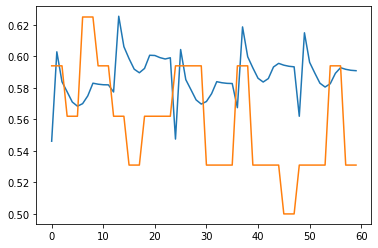

In [200]:
plt.plot(test_results['Univariate'])
plt.plot(test_results['Actuals'])

In [201]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Univariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',fillcolor='#ff0000',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [202]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Univariate'])
RMSE = math.sqrt(MSE)
RMSE

0.04744161849001166

In [203]:
from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Univariate'])
corr

-0.21833641684850755

In [204]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Univariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

0.02760703575611112

In [205]:

test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multi-step/multivariate_12jam_lstm_Belawan.csv')